In [27]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [28]:
# df = pd.read_csv("/content/drive/MyDrive/Kathmandu-Precipitation/data/06-season-masking-on-not-transformed-data.csv")
# df.drop(columns=["solarenergy",
#                  "orographic_precipitation_potential",
#                  "urban_heat_island_effect_refined",
#                  "valley_temperature_inversion_index",
#                  "windspeed","winddir","season",
#                  "winddir_cos","winddir_sin",'dew',"month_cos",
#                  "month_sin","temp"],inplace=True)

df = pd.read_csv("/content/drive/MyDrive/Kathmandu-Precipitation/data/Outlier-removed-dataset.csv")

In [29]:
features = [ i for i in df.columns if i not in ["precipitation","datetime"]]
target = ["precipitation"]
X = df[features]

y = df[target]

In [30]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [31]:
rf_model = RandomForestRegressor(random_state=42)


In [32]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Perform Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of random combinations to try
    scoring='neg_mean_squared_error',
    cv=3,  # Cross-validation folds
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Fit the Randomized Search to the training data
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [33]:
best_rf_model = random_search.best_estimator_
print(best_rf_model)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=5, random_state=42)


## RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=4,                    min_samples_split=10, random_state=42)

In [34]:
y_pred = best_rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}
Mean Squared Error: 15.146705416757415
Mean Absolute Error: 2.6266145287415013


In [35]:
new_data = X.iloc[52].values.reshape(1, -1)
predicted_precipitation = best_rf_model.predict(new_data)
print(f"Predicted Precipitation: {predicted_precipitation[0]}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Predicted Precipitation: 5.618963701186305


In [36]:
X.iloc[52]

,52
tempmax,84.10
tempmin,67.90
humidity,81.00
sealevelpressure,1005.40
cloudcover,67.70
season_sin,-0.59
season_cos,-0.81


In [37]:
#metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
# Compute metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Square root of MSE

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Mean Absolute Error (MAE): 2.6266
Root Mean Squared Error (RMSE): 3.8919


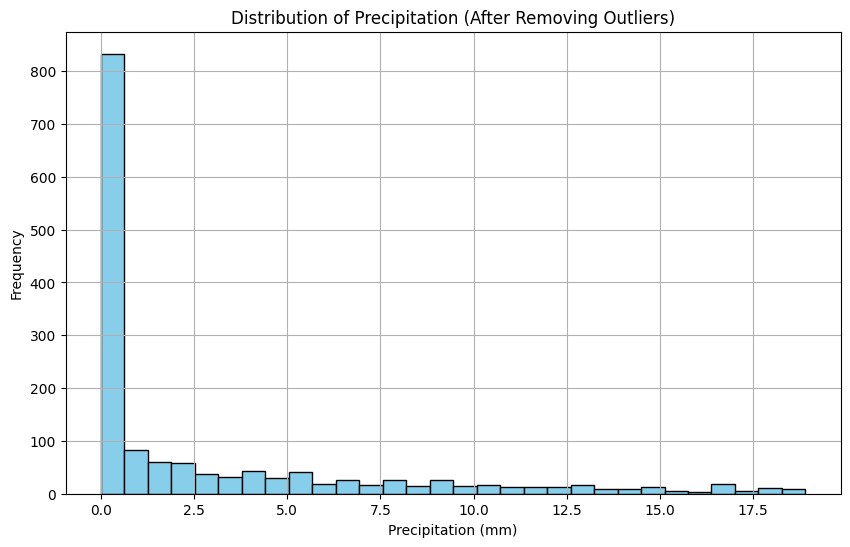

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df['precipitation'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Precipitation (After Removing Outliers)')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

(0.0, 20.79)

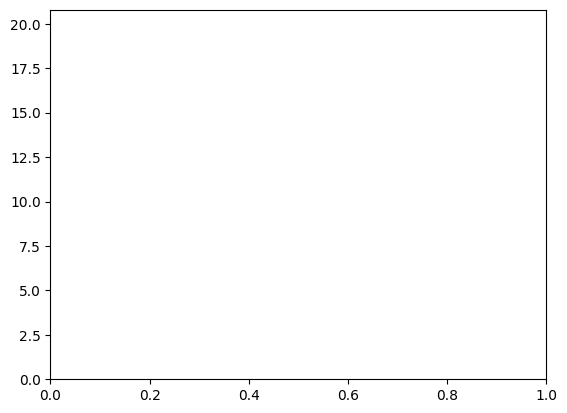

In [44]:
plt.ylim(0, max(df['precipitation'].max(), y_pred.max()) * 1.1)  # Add 10% padding

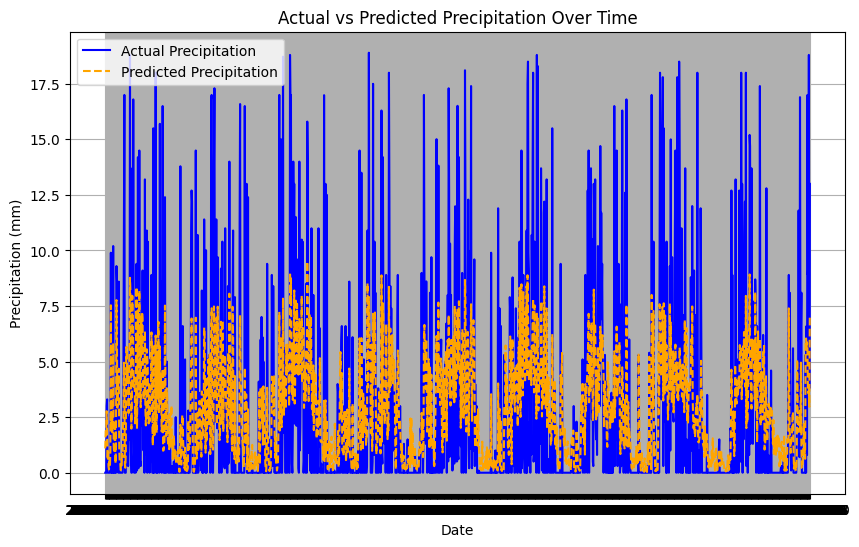

In [41]:
# Generate predictions for the full dataset
full_predictions = best_rf_model.predict(X)

# Plot actual vs predicted for the full dataset
plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['precipitation'], label='Actual Precipitation', color='blue')
plt.plot(df['datetime'], full_predictions, label='Predicted Precipitation', color='orange', linestyle='--')
plt.title('Actual vs Predicted Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.grid()
plt.show()